<h1>Testing of Multiple Resolution Density Matrices</h1>

<b>Description:</b> Here, I'm testing the calculation of two different size binned density matrices, one with higher resolution which covers a small local range around the galaxy, and a lower resolution one which covers the rest of the simulation box.
The tricky part here is that I am also shifting the coordinates so that the Halo does not move. Will work here on trying to work out how to do the needed analysis.

In [1]:
# Import Statements
import numpy as np
import scipy as sp
from scipy import integrate, interpolate
import scipy.fft as fft
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import h5py
import os
import time

In [2]:
# Global Rocket Parameters
xi = 50
Gmu = 1e-12
GammaFrac = 0.1
vf = 0.3
nRockets = 1000

# Global Simulation Parameters
tmax = 100
L = 1
binS = 100
zi = 127
dx = L / binS
h = 0.7
rhoScale = 4.78e-20 # Mpc / Msun

# Global Physical Parameters
t0 = 4213 / h # Mpc / h
H0 = 0.0003333

In [3]:
# Set the Environment
envi = 1
envs = ["Cluster", "Local"]
env = envs[envi]

if env == "Cluster":
    # Cluster dirs
    neilDir = "/cluster/tufts/hertzberglab/nshah14/"
    homeDir = "/cluster/tufts/hertzberglab/shared/Rockets/"
    simName = "Sim_100v"
    simDir = homeDir + simName + "/"
    Div = "/"
elif env == "Local":
    # Cluster dirs
    homeDir = "C:\\Users\\NeilShah\\Documents\\PhD\\Rocket Capture\\"
    simName = "Sim_100v"
    simDir = homeDir + simName + "\\"
    Div = "\\"

print("Working in the {} environment".format(env))

Working in the Local environment


Utility Functions

In [4]:
def getHubbleEvol():
    OMatter = 0.25
    OLambda = 0.75

    da_dt = lambda a, t: a * H0 * np.sqrt(OMatter / a**3 + OLambda)

    a0 = 1 / (1 + zi)
    tInt = np.linspace(0, 1.1 / H0, 1000)
    af = interpolate.InterpolatedUnivariateSpline(tInt, integrate.odeint(da_dt, y0=a0, t=tInt)[:, 0])
    aDotf = af.derivative(n=1)
    tEnd = sp.optimize.fsolve(lambda t: af(t) - 1.0, x0=(1.0 / H0))[0]

    tArr = np.asarray([(tEnd + t)**(t / tmax) - 1 for t in range(tmax)])
    aArr = np.asarray([af(t) for t in tArr])
    HArr = np.asarray([aDotf(t) / af(t) for t in tArr])

    return tArr, aArr, HArr

In [16]:
def getCoords(t):
    snapDir = simDir + "snapdir_{:03d}\\".format(t)
    pathArr = np.asarray(os.listdir(snapDir))
    
    ptypeN = 3
    coordsArr = [np.empty((0, 3), dtype=float) for i in range(ptypeN)]

    for pi in range(ptypeN):
        ptype = pi + 1
        for pathi in np.arange(0, pathArr.size):
            datGet = "/PartType{:d}/Coordinates".format(ptype)
            try:
                coords = np.asarray(h5py.File(snapDir + pathArr[pathi], 'r')[datGet])
                coordsArr[pi] = np.concatenate([coordsArr[pi], coords], axis=0)
            except KeyError:
                # print("   (Warning! Could not find ptype {:d} for snapshot t = {:d})".format(ptype, t))
                pass
    
    return(coordsArr)

def getHaloCoords(t):
    groupDir = simDir + "groups_{:03d}\\".format(t)
    snapDir = simDir + "snapdir_{:03d}\\".format(t)
    groupPaths = np.asarray(os.listdir(groupDir))
    snapPaths = np.asarray(os.listdir(snapDir))

    ptype = 1
    coordsArr = np.empty((0, 3), dtype=float)

    for i, pathi in enumerate(snapPaths):
        datGet = "/PartType{:d}/Coordinates".format(ptype)
        try:
            coords = np.asarray(h5py.File(snapDir + pathi, 'r')[datGet])
            coordsArr = np.concatenate([coordsArr, coords], axis=0)
        except KeyError:
            # print("   (Warning! Could not find ptype {:d} for snapshot t = {:d})".format(ptype, t))
            pass
    
    haloCoords = np.empty((0, 0))
    for i, pathi in enumerate(groupPaths):
        gfile = h5py.File(groupDir + pathi, 'r')
        try:
            haloInit = int(np.asarray(gfile["/Group/GroupOffsetType/"])[0, 0])
            haloN = int(np.asarray(gfile["/Group/GroupLen/"])[0])
            haloCoords = coordsArr[haloInit:(haloInit + haloN + 1), :]
            break
        except KeyError:
            pass
    
    return(haloCoords)

test = getHaloCoords(50)
test.shape[0] == 0

False

In [6]:
def getMass():
    tFix = 50
    massTab = np.zeros(3)

    snapDir = simDir + "snapdir_{:03d}/".format(tFix)
    path1 = snapDir + "snapshot_{:03d}.0.hdf5".format(tFix)
    fil = h5py.File(path1, 'r')

    ptypeN = 3
    for pi in np.arange(0, ptypeN):
        ptype = pi + 1
        datGet = "/PartType{:d}/Masses".format(ptype)
        massTab[pi] = np.asarray(fil[datGet])[0]

    return massTab

In [7]:
def getRhox(coords, L, bins, xc):
    dx = L / bins
    ptypeN = 3
    massArr = getMass()
    rhox = np.zeros((bins, bins, bins))
    for pi in np.arange(0, ptypeN):
        ptype = pi + 1
        mi = massArr[pi]

        for ci, coord in enumerate(coords[pi]):
            i, j, k = list(map(int, np.floor((coord - (xc - L/2)) / dx)))
            try:
                rhox[i, j, k] += mi
            except IndexError:
                pass
        
    rhox *= rhoScale * 1e10
    return(rhox)

In [8]:
haloCoords = getHaloCoords(50)
haloCoordsF = getHaloCoords(tmax)
haloC = np.asarray([np.mean(haloCoords[:, i]) for i in range(3)])
haloCF = np.asarray([np.mean(haloCoordsF[:, i]) for i in range(3)])
coords = getCoords(50)

print(haloC - haloCF)

[-6.65465719 -8.42849488 -6.56765326]


In [9]:
xc = np.asarray([60, 60, 60])
dx = 1
for ci, coord in enumerate(coords[0][:10, :]):
    print(coord)
    ijk = list(map(int, np.floor((coord - (xc - L/2)) / dx)))
    print(ijk, end="\n\n")

[43.66897964 41.87187576 43.92634964]
[-16, -18, -16]

[43.66650009 41.87121201 43.92863464]
[-16, -18, -16]

[43.66616821 41.87207031 43.93015671]
[-16, -18, -16]

[43.66713715 41.87012482 43.93041611]
[-16, -18, -16]

[43.66683197 41.86933899 43.92781448]
[-16, -18, -16]

[43.66946793 41.87183762 43.92746353]
[-16, -18, -16]

[43.66740799 41.87054062 43.9315033 ]
[-16, -18, -16]

[43.6684494  41.87451935 43.93010712]
[-16, -18, -16]

[43.66822052 41.86917496 43.92892075]
[-16, -18, -16]

[43.66939545 41.87083435 43.92508316]
[-16, -18, -16]



In [10]:
xc0 = np.asarray([50, 50, 50])
rhoxT = getRhox(coords, L=100, bins=100, xc=xc0)
rhoxTShift = getRhox(coords, L=100, bins=100, xc=haloCF)

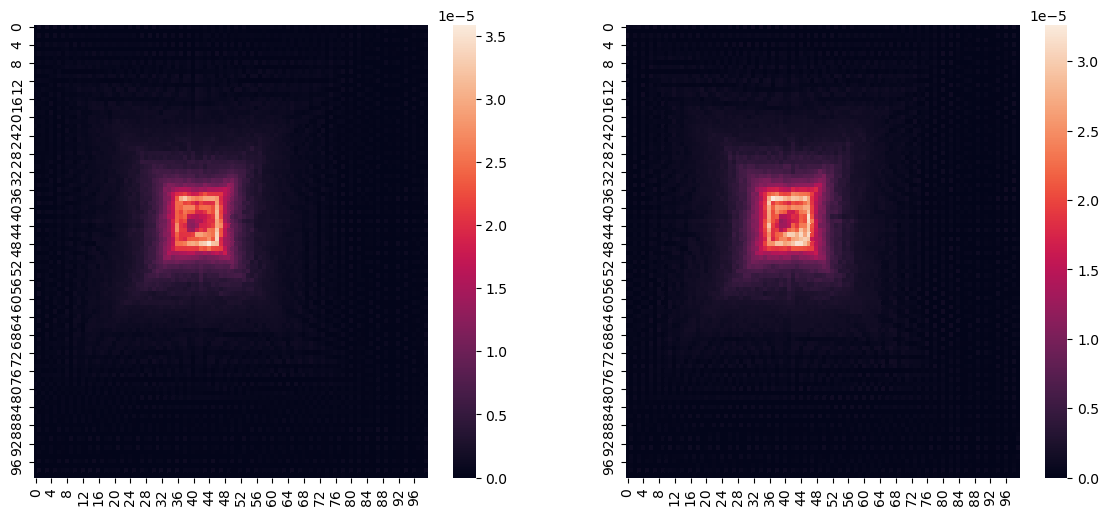

In [11]:
fig1, axs = plt.subplots(1, 2, figsize=(14, 6), dpi=100)
sns.heatmap(np.sum(rhoxT, axis=2), ax=axs[0])
sns.heatmap(np.sum(rhoxTShift, axis=2), ax=axs[1])
plt.show()

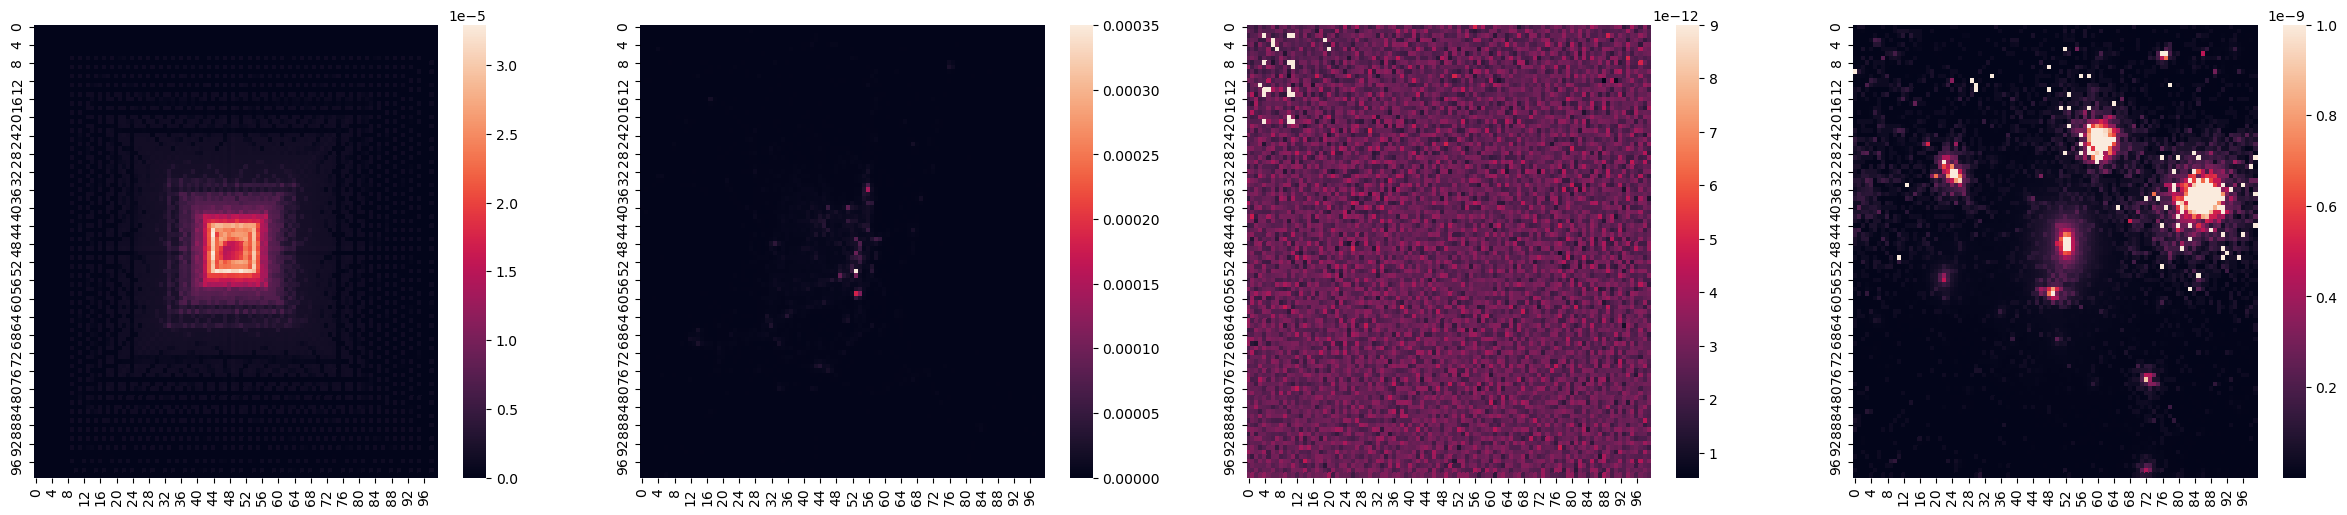

In [29]:
testDir1 = homeDir + "rhox_HaloCentered\\rhox_HC__L_{:03d}_{:03d}__bins_{:04d}\\".format(int(np.floor(100)), int(1e3 * np.mod(100, 1)), 100)
testDir2 = homeDir + "rhox_HaloCentered\\rhox_HC__L_{:03d}_{:03d}__bins_{:04d}\\".format(int(np.floor(1)), int(1e3 * np.mod(1, 1)), 100)
testL1t1 = np.load(testDir1 + "rhox_HC__L_{:03d}_{:03d}__bins_{:04d}__t_{:03d}.npy".format(int(np.floor(100)), int(1e3 * np.mod(100, 1)), 100, 0))
testL1t2 = np.load(testDir1 + "rhox_HC__L_{:03d}_{:03d}__bins_{:04d}__t_{:03d}.npy".format(int(np.floor(100)), int(1e3 * np.mod(100, 1)), 100, 99))
testL2t1 = np.load(testDir2 + "rhox_HC__L_{:03d}_{:03d}__bins_{:04d}__t_{:03d}.npy".format(int(np.floor(1)), int(1e3 * np.mod(1, 1)), 100, 0))
testL2t2 = np.load(testDir2 + "rhox_HC__L_{:03d}_{:03d}__bins_{:04d}__t_{:03d}.npy".format(int(np.floor(1)), int(1e3 * np.mod(1, 1)), 100, 99))

fig1, axs = plt.subplots(1, 4, figsize=(30, 6), dpi=100)
sns.heatmap(np.sum(testL1t1, axis=2), ax=axs[0])
sns.heatmap(np.sum(testL1t2, axis=2), ax=axs[1])
sns.heatmap(np.sum(testL2t1, axis=2), ax=axs[2], vmax=9e-12)
sns.heatmap(np.sum(testL2t2, axis=2), ax=axs[3], vmax=1e-9)
plt.show()